### Setting up the stage!

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import pyplot as plt

### User Input Required!

In [2]:
# Add the csv file name and location here!
# Get the file under DCA Bot > My Deals > Deals History > Export
source = "data/3commas-dca-deals-2021-01-01-2021-01-08.csv"

### Other variables

In [3]:
# Creates empty dataframe
summary = pd.DataFrame()
summary.index.name = "Bot ID"
bots = pd.DataFrame()
bots.index.name = "Bot ID" 

#TODO REVIEW ALL STATUSES
trade_status_closed = ["completed", "stop_loss_finished"]
trade_status_wins = ["completed"]
trade_status_losses = ["stop_loss_finished"]
trade_status_active = ["bought"] 

In [4]:
# those_columns = ["close_date", "bot", "final_profit", "loss", "win", "used_safety_orders", "pair"]
# bot_settings = ["take_profit_condition", "base_order_volume", "safety_order_volume"]

result_columns = ["win", "loss", "final_profit"]
those_columns = ["close_date", "bot", "final_profit", "loss", "win", "used_safety_orders", 
                 "pair", "take_profit_condition", "base_order_volume", "safety_order_volume"]

### Grabbing the data

In [5]:
data = pd.read_csv(source,
                   sep=";",
                   index_col="deal_id",
                   header=0,
                   parse_dates=['closed_at'])

In [6]:
# Sorting per close_date
data = data.sort_values(by='close_date',ascending=True)

### TO-DO!

**IMPORTANT!** Must make a distinction between profit in base and quote! 🙀 

### Raise an error if there's more than one base

In [7]:
# Check if the base asset is the same in all pairs 
base_pair = data["pair"].str.split("_").str[0].unique()
if len(base_pair) == 1:
    base_pair = base_pair[0]
else:
    raise("ERROR! 🙀 More than one base, not prepared for that!")

### Filtering the data

In [8]:
# Data range
# Comment all to get the entire data

# Slicing per date range
# data = data[(data["close_date"] >= "2021-01-01") &
#            (data["close_date"] <= "2021-01-04")]

# Only after/before/equal a certain date
data = data[(data["close_date"] >= "2021-01-01")]

In [9]:
# ONLY this(these) bot(s)!
# data = data[data["bot"] == "RSI7 < 30 3m"]

In [10]:
# REMOVE these bots!
# bots_remove = ["Gordon-LEV-Conservative", "Gordon-LEV-Moderate", 
#                "Gordon-Conservative", "Gordon-Agressive"]
# data = data[~data["bot"].isin(bots_remove)]

### Replace NANs from "final_profit" feature withzeros

In [11]:
data['final_profit'] = data['final_profit'].fillna(0)

### Add features

In [12]:
# Add "win" feature with the sum of positive profits of the day
data["win"] = np.where(data["final_profit"] >0, data["final_profit"], 0)
# Add 'loss' column with the sum of negative profits of the day as a ABS number
data["loss"] = np.where(data["final_profit"] <0, data["final_profit"], 0)
data["loss"] = data["loss"].abs()

In [13]:
# Add "cum_profit" feature
# data["cum_profit"] = data["final_profit"].cumsum()

In [14]:
# Closed Trade feature
# data["closed"] = 0
data["closed"] = data["status"].apply(lambda x: 1 if x in (trade_status_closed) else 0)

### Generate Report

**IMPORTANT!** Whenever we have mean() with rows with zero value, math might be wrong!

In [15]:
for bot_id in data["bot_id"].unique():
    trades_total = len(data[(data["bot_id"] == bot_id)])
    trades_closed = data[(data["bot_id"] == bot_id)]["closed"].sum()
    trades_win = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_wins))])*100 / trades_closed
    trades_win = round(trades_win, 2)
    trades_losses = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_losses))])*100 / trades_closed
    trades_losses = round(trades_losses, 2)
    trades_duration_avg = data[data["bot_id"] == bot_id]["duration"].mean()
    trades_duration_avg = pd.to_datetime(trades_duration_avg, unit="s")
    trades_so_avg = data[data["bot_id"] == bot_id]["used_safety_orders"].mean()
    trades_so_max = data[data["bot_id"] == bot_id]["max_safety_orders_count"].iloc[0] 
    #TODO: NOT WORKING!
    trades_so_max_avg = len(data[(data["bot"] == bot_id) & 
                                 (data["used_safety_orders"] == data["max_safety_orders_count"].max())])
    trades_so_max_avg = (trades_so_max_avg *100)/trades_closed
    
    # Add data to Summary dataframe
    summary.loc[bot_id, "Bot Name"] = data[data["bot_id"] == bot_id]["bot"].unique()
    summary.loc[bot_id, "AVG Profit (%)"] = round(data[(data["bot_id"] == bot_id)]["profit_percentage_from_total_volume"].mean(),2)
    profit_column_name = f"Profit ({base_pair})"
    summary.loc[bot_id, profit_column_name] = data[(data["bot_id"] == bot_id) & (~data["status"].isin(trade_status_active))]["final_profit"].sum()
    summary.loc[bot_id, "Win (%)"] = trades_win
    summary.loc[bot_id, "Loss (%)"] = trades_losses
    summary.loc[bot_id, "Closed Trades"] = data[data["bot_id"] == bot_id]["closed"].sum()
    summary.loc[bot_id, "AVG Trade Duration"] = trades_duration_avg
    summary.loc[bot_id, "Max SO Set"] = trades_so_max
    #TODO: NOT WORKING!
    summary.loc[bot_id, "Max SO Used (%)"] = trades_so_max_avg
    summary.loc[bot_id, "AVG SO/Trade"] = trades_so_avg
    # TODO: AVG DEALS PER DAY/TIME THE BOT HAS BEEN ACTIVE // REQUIRES INFO IN THE SOURCE DATA

summary["Closed Trades"] = summary["Closed Trades"].astype(int) 
summary["AVG Trade Duration"] = summary["AVG Trade Duration"].dt.strftime("%H:%M:%S")
summary

<ipython-input-15-8171a66c24e6>:4: RuntimeWarning: invalid value encountered in long_scalars
  trades_win = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_wins))])*100 / trades_closed
<ipython-input-15-8171a66c24e6>:6: RuntimeWarning: invalid value encountered in long_scalars
  trades_losses = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_losses))])*100 / trades_closed
<ipython-input-15-8171a66c24e6>:15: RuntimeWarning: invalid value encountered in long_scalars
  trades_so_max_avg = (trades_so_max_avg *100)/trades_closed


,Bot Name,AVG Profit (%),Profit (USDT),Win (%),Loss (%),Closed Trades,AVG Trade Duration,Max SO Set,Max SO Used (%),AVG SO/Trade
Bot ID,,,,,,,,,,
2145929,Gordon-Agressive,0.77,1.523833,100.00,0.00,1,21:35:02,3.0,0.0,3.000000
2145925,Gordon-Moderate,2.29,368.979563,98.00,2.00,50,03:25:57,3.0,0.0,0.840000
2281779,TBT Signals,1.38,116.391950,100.00,0.00,20,03:06:16,2.0,0.0,0.708333
2292725,RSI7 < 30 3m,0.70,13.445974,87.63,12.37,97,01:16:52,2.0,0.0,0.704082
2297369,Gordon-Moderate-TP1.5-SL8,1.71,22.648991,100.00,0.00,7,01:07:59,3.0,0.0,0.142857
2314379,RSI7 < 30 3m BTC ETH BNB ACCUM,2.95,57.997438,100.00,0.00,12,04:05:25,1.0,0.0,0.583333
2313262,RSI7 < 30 3m OTHER COINS,0.06,-30.023255,69.23,30.77,26,02:59:17,1.0,0.0,0.444444
2314271,Gordon-Moderate BTC ETH BNB ACCUM,0.00,0.000000,NaN,NaN,0,00:00:01,3.0,NaN,0.000000


# "Profit (USDT)" above is wrong!!! ^^^

In [16]:
closed_trades = len(data[data["status"].isin(trade_status_closed)])
total_profit = data["final_profit"].sum()
print(f"Total number of closed trades: {closed_trades}")
print(f"Total profit: ${total_profit}")

Total number of closed trades: 213
Total profit: $550.9644928100001


### Paintbrush

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 1.0, '3Commas DCA Bots')

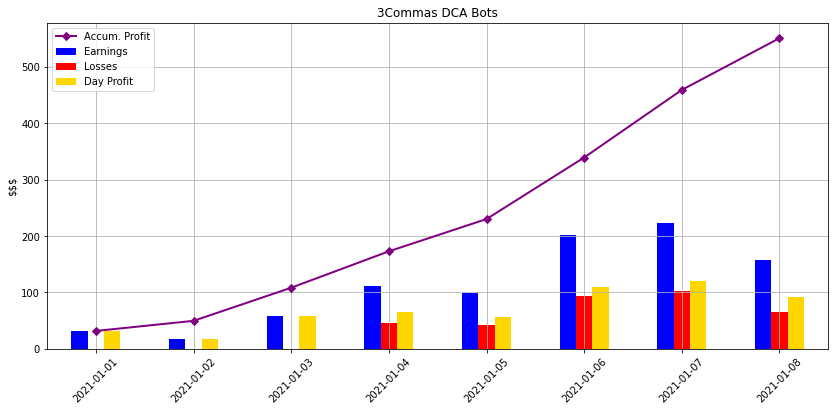

In [17]:
ax = data.groupby("close_date")["final_profit"].sum().cumsum().plot( 
                                                               marker='D',
                                                               lw=2,
                                                               color="purple")

data.groupby("close_date")[["win", "loss", "final_profit"]].sum().plot(ax=ax,
                                                       kind="bar",
                                                       figsize=(14,6),
                                                       grid=True,
                                                       color=["blue", "red", "gold"],
                                                       rot=45)

ax.legend(["Accum. Profit",  "Earnings", "Losses", "Day Profit"])
ax.set_xlabel("")
ax.set_ylabel("$$$")
plt.title("3Commas DCA Bots")

# Bots

Text(0.5, 1.0, '3Commas DCA Bots')

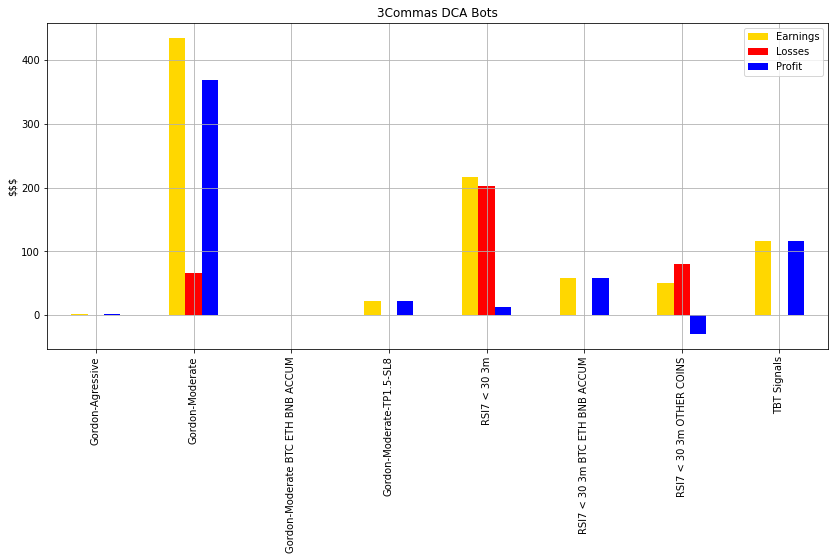

In [18]:
ax = data.groupby("bot")[result_columns].sum().plot(kind="bar",
                                                    figsize=(14,6),
                                                    grid=True,
                                                    color=["gold", "red", "blue"],
                                                    rot=90)

ax.legend(["Earnings", "Losses", "Profit"])
ax.set_xlabel("")
ax.set_ylabel("$$$")
plt.title("3Commas DCA Bots")

### Bots Settings (Current!)

In [19]:
for bot_id in data["bot_id"].unique():
    bots.loc[bot_id, "bot"] = data[(data["bot_id"] == bot_id)]["bot"].unique()
    bots.loc[bot_id, "TP"] = data[(data["bot_id"] == bot_id)]["take_profit_condition"].iloc[-1]
    bots.loc[bot_id, "SO Count"] = data[(data["bot_id"] == bot_id)]["max_safety_orders_count"].iloc[-1]
    bots.loc[bot_id, "SO%"] = data[(data["bot_id"] == bot_id)]["safety_order_step_percentage"].iloc[-1]
    bots.loc[bot_id, "SO Vol"] = data[(data["bot_id"] == bot_id)]["safety_order_volume"].iloc[-1]
    bots.loc[bot_id, "Closed"] = data[(data["bot_id"] == bot_id)]["closed"].sum()

bots

,bot,TP,SO Count,SO%,SO Vol,Closed
Bot ID,,,,,,
2145929,Gordon-Agressive,1.00,3.0,2.5,54.0,1.0
2145925,Gordon-Moderate,2.50,3.0,2.5,250.0,50.0
2281779,TBT Signals,1.75,2.0,1.5,300.0,20.0
2292725,RSI7 < 30 3m,1.90,2.0,1.5,150.0,97.0
2297369,Gordon-Moderate-TP1.5-SL8,1.50,3.0,2.0,200.0,7.0
2314379,RSI7 < 30 3m BTC ETH BNB ACCUM,2.50,1.0,2.0,100.0,12.0
2313262,RSI7 < 30 3m OTHER COINS,1.88,1.0,2.0,100.0,26.0
2314271,Gordon-Moderate BTC ETH BNB ACCUM,5.00,3.0,2.5,150.0,0.0


### Profit per day

In [20]:
data.groupby("close_date")["closed", "win", "loss", "final_profit"].sum()

<ipython-input-20-512d7177009a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby("close_date")["closed", "win", "loss", "final_profit"].sum()


,closed,win,loss,final_profit
close_date,,,,
2021-01-01,3,31.682559,0.000000,31.682559
2021-01-02,3,17.927037,0.000000,17.927037
2021-01-03,10,58.711944,0.000000,58.711944
2021-01-04,31,110.896645,46.312724,64.583921
2021-01-05,49,98.619399,41.413390,57.206009
2021-01-06,64,202.052367,92.862697,109.189670
2021-01-07,41,222.877981,103.004428,119.873553
2021-01-08,12,157.257561,65.467761,91.789800


### Bots per day

In [21]:
data.groupby(["close_date", "bot"])["closed", "win", "loss", "final_profit"].sum()

<ipython-input-21-658523039dcd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby(["close_date", "bot"])["closed", "win", "loss", "final_profit"].sum()


closed         win       loss  \
close_date bot                                                                
2021-01-01 Gordon-Agressive                        1    1.523833   0.000000   
           Gordon-Moderate                         2   30.158726   0.000000   
2021-01-02 Gordon-Moderate                         3   17.927037   0.000000   
2021-01-03 Gordon-Moderate                         7   57.169089   0.000000   
           TBT Signals                             3    1.542855   0.000000   
2021-01-04 Gordon-Moderate                        11   66.506665   0.000000   
           RSI7 < 30 3m                           15   22.906771  46.312724   
           TBT Signals                             5   21.483209   0.000000   
2021-01-05 Gordon-Moderate                         4   10.586909   0.000000   
           Gordon-Moderate-TP1.5-SL8               4    8.845729   0.000000   
           RSI7 < 30 3m                           37   59.311698  41.413390   
           TBT Signals                             4   19.875063   0.000000   
2021-01-06 Gordon-Moderate                         8   57.108417   0.000000   
           Gordon-Moderate-TP1.5-SL8               3   13.803262   0.000000   
           RSI7 < 30 3m                           34   75.020748  49.310108   
           RSI7 < 30 3m BTC ETH BNB ACCUM          2    9.640317   0.000000   
           RSI7 < 30 3m OTHER COINS               13   23.633000  43.552589   
           TBT Signals                             4   22.846624   0.000000   
2021-01-07 Gordon-Moderate                         7   85.381653   0.000000   
           RSI7 < 30 3m                           10   56.709957  65.858899   
           RSI7 < 30 3m BTC ETH BNB ACCUM         10   48.357121   0.000000   
           RSI7 < 30 3m OTHER COINS               13   27.041863  37.145529   
           TBT Signals                             1    5.387387   0.000000   
2021-01-08 Gordon-Moderate                         8  109.608828  65.467761   
           Gordon-Moderate BTC ETH BNB ACCUM       0    0.000000   0.000000   
           RSI7 < 30 3m                            1    2.391921   0.000000   
           TBT Signals                             3   45.256811   0.000000   

                                              final_profit  
close_date bot                                              
2021-01-01 Gordon-Agressive                       1.523833  
           Gordon-Moderate                       30.158726  
2021-01-02 Gordon-Moderate                       17.927037  
2021-01-03 Gordon-Moderate                       57.169089  
           TBT Signals                            1.542855  
2021-01-04 Gordon-Moderate                       66.506665  
           RSI7 < 30 3m                         -23.405954  
           TBT Signals                           21.483209  
2021-01-05 Gordon-Moderate                       10.586909  
           Gordon-Moderate-TP1.5-SL8              8.845729  
           RSI7 < 30 3m                          17.898308  
           TBT Signals                           19.875063  
2021-01-06 Gordon-Moderate                       57.108417  
           Gordon-Moderate-TP1.5-SL8             13.803262  
           RSI7 < 30 3m                          25.710640  
           RSI7 < 30 3m BTC ETH BNB ACCUM         9.640317  
           RSI7 < 30 3m OTHER COINS             -19.919589  
           TBT Signals                           22.846624  
2021-01-07 Gordon-Moderate                       85.381653  
           RSI7 < 30 3m                          -9.148942  
           RSI7 < 30 3m BTC ETH BNB ACCUM        48.357121  
           RSI7 < 30 3m OTHER COINS             -10.103666  
           TBT Signals                            5.387387  
2021-01-08 Gordon-Moderate                       44.141067  
           Gordon-Moderate BTC ETH BNB ACCUM      0.000000  
           RSI7 < 30 3m                           2.391921  
           TBT Signals                        

# Pairs

Text(0, 0.5, '$$$')

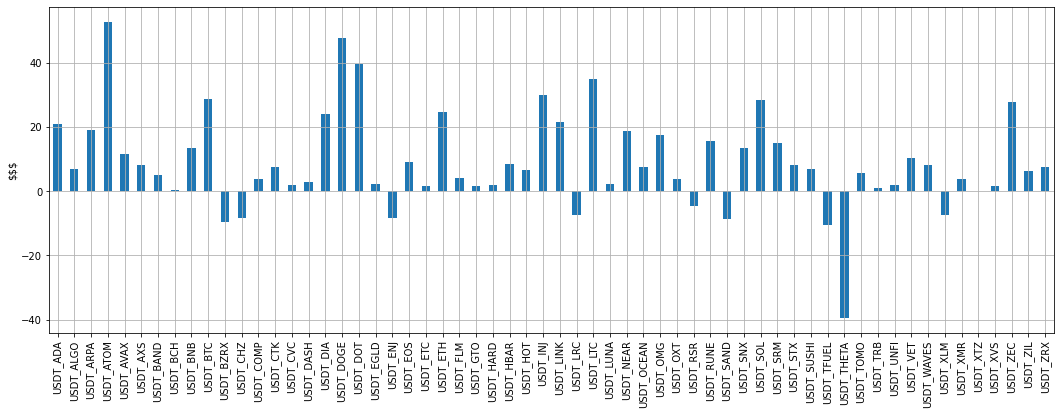

In [24]:
ax = data.groupby("pair")["final_profit"].sum().plot(kind="bar", 
                                                     figsize=(18,6),
                                                     grid=True)
ax.set_xlabel("")
ax.set_ylabel("$$$")

In [37]:
data[data["close_date"] == "2021-01-08"].groupby("bot")["closed", "win", "loss", "final_profit"].sum()

<ipython-input-37-f75f70744aa8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data[data["close_date"] == "2021-01-08"].groupby("bot")["closed", "win", "loss", "final_profit"].sum()


,closed,win,loss,final_profit
bot,,,,
Gordon-Moderate,8,109.608828,65.467761,44.141067
Gordon-Moderate BTC ETH BNB ACCUM,0,0.000000,0.000000,0.000000
RSI7 < 30 3m,1,2.391921,0.000000,2.391921
TBT Signals,3,45.256811,0.000000,45.256811


In [33]:
data[data["status"] == "failed"][those

,close_date,bot,final_profit,loss,win,used_safety_orders,pair,take_profit_condition,base_order_volume,safety_order_volume
deal_id,,,,,,,,,,
252448807,2021-01-05,RSI7 < 30 3m,0.0,0.0,0.0,1,USDT_DOGE,1.00,100.0,100.0
254878516,2021-01-07,RSI7 < 30 3m OTHER COINS,0.0,0.0,0.0,1,USDT_THETA,1.88,100.0,100.0
256224449,2021-01-08,Gordon-Moderate BTC ETH BNB ACCUM,0.0,0.0,0.0,0,USDT_ETH,5.00,150.0,150.0
256234304,2021-01-08,TBT Signals,0.0,0.0,0.0,0,USDT_ADA,1.75,300.0,300.0
256231124,2021-01-08,TBT Signals,0.0,0.0,0.0,0,USDT_DOT,1.75,300.0,300.0
256230187,2021-01-08,TBT Signals,0.0,0.0,0.0,0,USDT_XLM,1.75,300.0,300.0
256226736,2021-01-08,TBT Signals,0.0,0.0,0.0,0,USDT_XTZ,1.75,300.0,300.0


In [36]:
data[data["bot"] == "TBT Signals"]["closed"].sum()

20